In [32]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.tsa.seasonal as seasonal
import numpy as np
%matplotlib inline
plt.style.use('Solarize_Light2')

In [40]:
df = pd.read_csv('monthly-milk-production.csv')

In [41]:
df = df.rename(columns={'Milk Production':'data'})

In [42]:
df['Month'] = pd.to_datetime(df['Month'],format='%Y-%m-%d').dt.date
df = df.set_index('Month')
df = df.asfreq(freq='MS', method='ffill')
df.head()

,data
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive')
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

Month
1962-01-01   NaN
1962-02-01   NaN
1962-03-01   NaN
1962-04-01   NaN
1962-05-01   NaN
              ..
1975-08-01   NaN
1975-09-01   NaN
1975-10-01   NaN
1975-11-01   NaN
1975-12-01   NaN
Freq: MS, Name: trend, Length: 168, dtype: float64
Month
1962-01-01    -18.669605
1962-02-01    -58.858707
1962-03-01     34.897703
1962-04-01     49.913729
1962-05-01    110.407318
                 ...    
1975-08-01     -9.563835
1975-09-01    -51.926015
1975-10-01    -48.679220
1975-11-01    -79.467682
1975-12-01    -43.156784
Freq: MS, Name: seasonal, Length: 168, dtype: float64
Month
1962-01-01   NaN
1962-02-01   NaN
1962-03-01   NaN
1962-04-01   NaN
1962-05-01   NaN
              ..
1975-08-01   NaN
1975-09-01   NaN
1975-10-01   NaN
1975-11-01   NaN
1975-12-01   NaN
Freq: MS, Name: resid, Length: 168, dtype: float64
Month
1962-01-01    589.0
1962-02-01    561.0
1962-03-01    640.0
1962-04-01    656.0
1962-05-01    727.0
              ...  
1975-08-01    858.0
1975-09-01    817.0
1975-10-01 

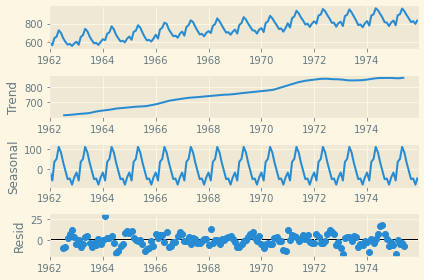

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

result = seasonal_decompose(df, model='additive')
result.plot()
pyplot.show()

In [25]:
import statsmodels.api as sm
from statsmodels.api import OLS

In [26]:
x, y = np.arange(len(decomposition.trend.dropna())), decomposition.trend.dropna()
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())
fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(decomposition.trend.dropna().values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(decomposition.trend.dropna()))])
ax[1].plot(res.resid.values);
ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='r');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

NameError: name 'decomposition' is not defined

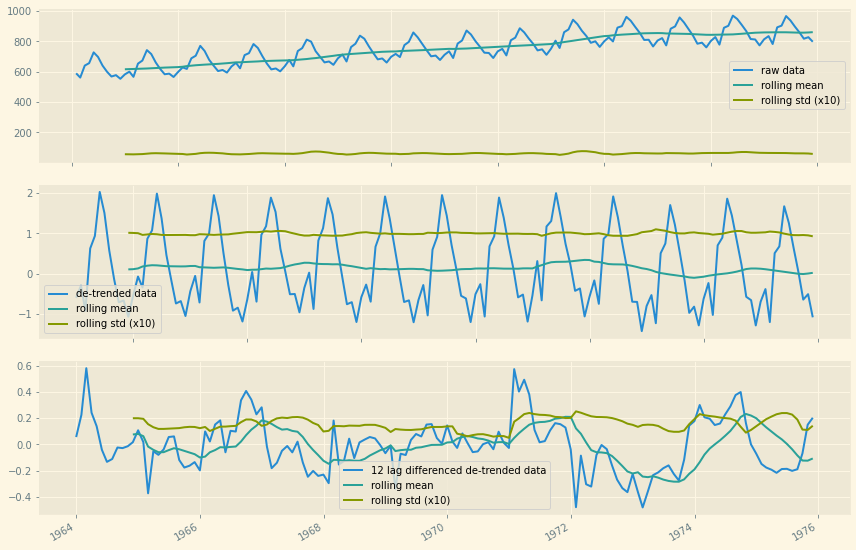

In [13]:
plot_rolling(df)

## Augmented Dickey-Fuller Test

In [14]:
from statsmodels.tsa.stattools import adfuller

In [16]:
print(" > Is the data stationary ?")
dftest = adfuller(df.data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -1.417
P-value = 0.574
Critical values :
	1%: -3.473829775724492 - The data is not stationary with 99% confidence
	5%: -2.880622899711496 - The data is not stationary with 95% confidence
	10%: -2.5769448985432954 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.744
P-value = 0.067
Critical values :
	1%: -3.477261624048995 - The data is not stationary with 99% confidence
	5%: -2.8821181874544233 - The data is not stationary with 95% confidence
	10%: -2.5777431104939494 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.193
P-value = 0.020
Critical values :
	1%: -3.481281802271349 - The data is not stationary with 99% confidence
	5%: -2.883867891664528 - The data is  stationary with 95% confidence
	10%: -2.5786771965503177 - The data is  stationary with 90% confidence


## Autocorrelation plots (ACF & PACF)

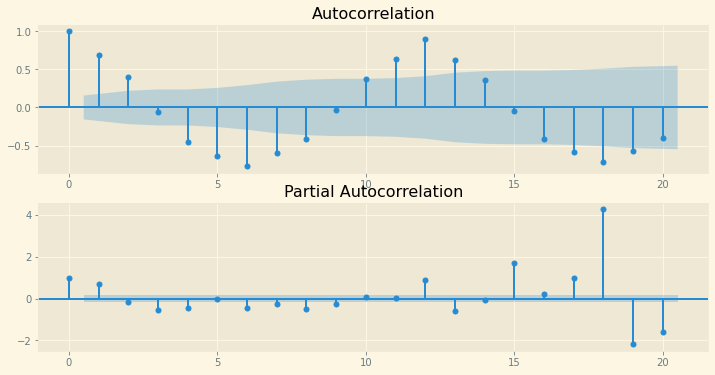

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=20)